# 5. Finetuning a model

Lastly, we will show how we can finetune a BERT model for any classification task we want. Finetuning involves training (with a very small learning rate) all of the parameters of the model for a particular task. This is one of the most powerful ways of using modern language models.

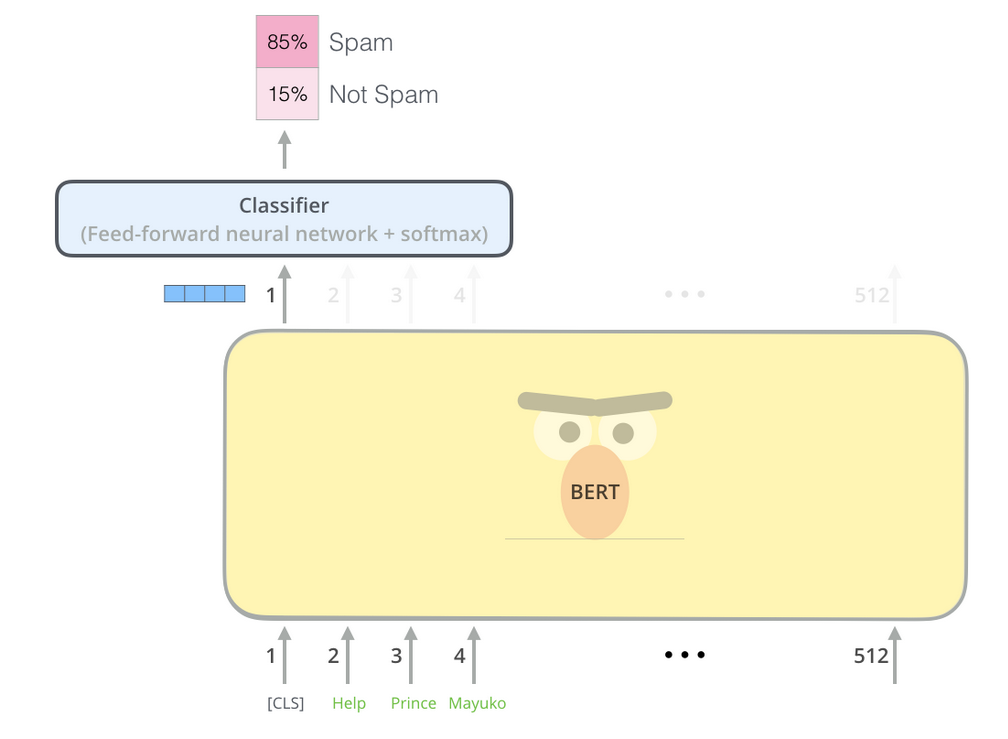

*Source: Alammar (2018)*

In [ ]:
# format the train data adequately
df_finetune = df.loc[train_idxs].copy()

df_finetune = df_finetune[["sentences", "naics2"]]
df_finetune.columns = ["sentences", "label"]

# transform labels into integers
df_finetune["label"] = df_finetune["label"].astype(int)
df_finetune

# map labels from original sector code to ints from 0 to num_sectors
num_sectors = len(df_finetune.groupby('label').size())
label2id_label = {k:v for k,v in zip(df_finetune.groupby('label').size().index.values, range(0, num_sectors))}
df_finetune["label"] = df_finetune["label"].apply(lambda x: label2id_label[x])
df_finetune

,sentences,label
3639,We experienced a work stoppage in 2008 when a ...,0
2680,"Finally, holders of the Tesla Convertible Note...",0
1507,There can be significant differences between o...,3
911,We also rely on other companies to maintain re...,2
621,The techniques used for attacks by third parti...,0
...,...,...
5007,Our revenues and cash requirements are affecte...,1
710,"As is common in our industry, our advertisers ...",2
6162,Global markets for the Company's products and ...,0
4138,"Longer payment cycles in some countries, incre...",2


In [ ]:
# format the test data adequately
df_test = df.loc[test_idxs].copy()

df_test = df_test[["sentences", "naics2"]]
df_test.columns = ["sentences", "label"]

# transform labels into integers
df_test["label"] = df_test["label"].astype(int)
df_test

# map labels from original sector code to ints from 0 to num_sectors
df_test["label"] = df_test["label"].apply(lambda x: label2id_label[x])
df_test

,sentences,label
1236,• integration of the acquired company's accou...,2
474,Competition for qualified personnel within the...,3
3418,Any reduction in our and our subsidiaries' cre...,3
6564,Natural disasters or other catastrophes could ...,1
2646,For the battery and drive unit on our current ...,0
...,...,...
1950,Regulatory requirements in the U.S. and in non...,3
6648,If personal information of our customers or em...,2
6529,The evolution of retailing in online and mobil...,1
6452,"Our success depends, in part, on our ability t...",1


In [ ]:
# transform data into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
# tokenize the dataset
def tokenize_function(examples):
    return sec_tokenizer(examples["sentences"], max_length=60, padding="max_length", truncation=True)

tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)    # batched=True is key for training
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_ft

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Dataset({
    features: ['sentences', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5438
})

In [ ]:
# load the model for finetunning. 
# NOTE that we use a different class from the transformers library:
# BertModel vs. BertForSequenceClassification
num_labels = len(df_finetune.groupby('label').size())
model_ft = BertForSequenceClassification.from_pretrained("nlpaueb/sec-bert-base", 
                                                         num_labels=num_labels,
                                                         output_hidden_states=False)

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

You can find a complete description of all the available parameters of the ```TrainingArguments()``` class [here](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
# define the main arguments for training
training_args = TrainingArguments("./",                               # path to save model
                                  learning_rate=3e-5,                 # we use a very small learning rate
                                  num_train_epochs=3,                 # number of iterations through the corpus
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=1,
                                  evaluation_strategy="no",
                                  save_strategy="no")

In [ ]:
# define the set of metrics to be computed through the training process
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    
    return {"precision": precision, "recall": recall, 
            "f1": f1, "accuracy": accuracy}

# by default the Trainer will use MSEloss from (torch.nn) for regression and
# CrossEntropy loss for classification
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_ft,  # in-sample evaluation
    compute_metrics=compute_metrics
)

In [ ]:
# train model (should take around 5 minutes with GPU)
trainer.train()

# save final version of the model
#trainer.save_model("./models/")

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentences, __index_level_0__. If sentences, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5438
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2040


Step,Training Loss
500,0.819600
1000,0.509100
1500,0.355000
2000,0.220800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2040, training_loss=0.47020868320091097, metrics={'train_runtime': 252.5766, 'train_samples_per_second': 64.59, 'train_steps_per_second': 8.077, 'total_flos': 503023926150720.0, 'train_loss': 0.47020868320091097, 'epoch': 3.0})

In [ ]:
# evaluate final model on the test dataset
results = trainer.predict(tokenized_test)
final_metrics = results[2]
print(final_metrics)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentences, __index_level_0__. If sentences, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1360
  Batch size = 1


{'test_loss': 0.9027439951896667, 'test_precision': 0.7764705882352941, 'test_recall': 0.7764705882352941, 'test_f1': 0.7764705882352941, 'test_accuracy': 0.7764705882352941, 'test_runtime': 16.5511, 'test_samples_per_second': 82.17, 'test_steps_per_second': 82.17}


In [ ]:
# compare all 4 methods
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert, test_acc_sec, final_metrics["test_accuracy"]],
                           "model": ["word_embeddings", "BERT", "SEC BERT", "Finetuned BERT"]})
df_compare

,accuracy,model
0,0.616176,word_embeddings
1,0.627206,BERT
2,0.708088,SEC BERT
3,0.776471,Finetuned BERT


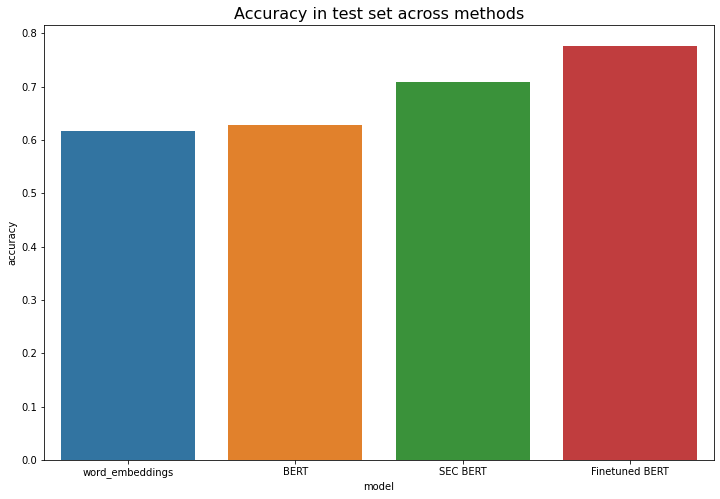

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()